In [1]:
import pandas as pd
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import GridSearchCV
from surprise.model_selection import split
from surprise.prediction_algorithms.knns import KNNBasic
from surprise.prediction_algorithms.co_clustering import CoClustering
from surprise import accuracy
from surprise.model_selection import cross_validate
from sklearn import metrics
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# implementing user based collaborative filtering under SVD
# read in ratings.txt and documents.txt into pandas

# ratings dataframe
rating_raw = pd.read_csv('fairgrecs-dataset/ratings.txt', sep = '\t', header = [0])

rating_raw = rating_raw.truncate(50, 50000) #matching with other datasets

# user features dataframe (features of keyword)
doc_raw = pd.read_csv('fairgrecs-dataset/documents.txt', sep = '\t', header = [0])



# passing in users and items
users = rating_raw['USER_ID'].values.flatten()
items = rating_raw['DOCUMENT_ID'].values.flatten()
ratings = rating_raw['RATE'].values.flatten()

# passing in user features 
feature_name = doc_raw['{KEYWORDS}'].values.flatten()
feature_value = doc_raw['DOCUMENT_ID'].values.flatten()

In [3]:
reader = Reader(rating_scale = (1,5))

data = Dataset.load_from_df(rating_raw[['USER_ID', 'DOCUMENT_ID', 'RATE']], reader)


In [4]:
trainset, testset = split.train_test_split(data, test_size=0.25)

In [6]:
AUC_scores = []
rmse_scores = []

total_coclusters = 30


for cocluster in range(1, total_coclusters ): #takes a while to run
    
    
    algo_coclustering = CoClustering(n_cltr_i = cocluster, n_cltr_u = cocluster)
    algo = algo_coclustering.fit(trainset)
    
    #test model
    predictions = algo.test(testset)    
    #cross validate

    results = cross_validate(
        algo = algo, data = data, measures=['RMSE'], 
        cv=5, return_train_measures=True
        )
    
    #get actual (index 2 of predictions) and estimates (index 3 of predictions)

    actual  = []
    predicts = []

    for i in range(len(predictions)):
        actual.append(predictions[i][2])
        predicts.append(predictions[i][3])

    fpr, tpr, thresholds = metrics.roc_curve(actual, predicts, pos_label=2)
    AUC_scores.append(metrics.auc(fpr, tpr))

    rmse_scores.append(results['test_rmse'].mean())

/var/folders/xw/gjkqcy4x1gqgcyvc45ys8srw0000gn/T/ipykernel_46633/572144377.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algo = algo_coclustering.fit(trainset)
/var/folders/xw/gjkqcy4x1gqgcyvc45ys8srw0000gn/T/ipykernel_46633/572144377.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your cu

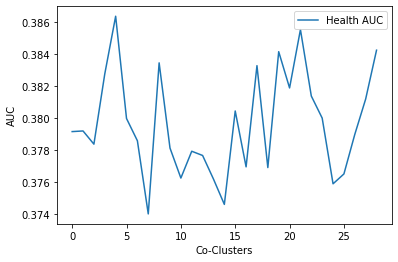

In [9]:
# Graph
x = np.arange(total_coclusters - 1)

plt.plot(x, np.array(AUC_scores))
plt.xlabel('Co-Clusters')
plt.ylabel('AUC')

plt.legend(['Health AUC'], loc = 'upper right')

plt.savefig('CF_Model_cocluster_Health.png', facecolor = 'w')